<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Adam/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price CS3244 project
The goals of this project are:
* To determine an effective model with justificaiton for predicting stock prices of the S&P500
* To determine if the S&P500 is a good indicator of performance for other companies contained in the top 500 performing companies

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Processing
For every stock or ETF being analysed, we chose to create a continuous data frame by choosing to include the average of the daily high and low as the constant day to day price between opening and closing. We made this decision because of the appropriate statisical representation the mean has of the high and low prices every day.

In [8]:
import pandas as pd
#here is a demonstration of preprocessing done on the S&P500 ETF
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)
# Create empty lists to store the new data
dates = []
prices = []
price_types = []

# Iterate through the DataFrame
for index, row in sp500.iterrows():
  date = row['Date']
  open_price = row['Open']
  high_price = row['High']
  low_price = row['Low']
  close_price = row['Close']

  # Append the data to the lists
  dates.extend([date] * 4)  # Repeat the date 4 times
  prices.extend([open_price, high_price, low_price, close_price])
  price_types.extend(['open', 'high', 'low', 'close'])

# Create a new DataFrame
sp500 = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

In [9]:
# Group the DataFrame by Date and Type of Price
grouped = sp500.groupby(['Date', 'Type of Price'])

# Calculate the average price for each date and type
avg_prices = grouped['Price'].mean().reset_index()

# Create a dictionary to store the average high and low prices for each date
avg_high_low = {}

# Iterate through the average prices
for index, row in avg_prices.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  price = row['Price']

  if date not in avg_high_low:
    avg_high_low[date] = {}

  if price_type == 'high' or price_type == 'low':
    avg_high_low[date][price_type] = price

# Iterate through the DataFrame and replace high and low prices with the average
for index, row in sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']

  if price_type == 'high' or price_type == 'low' and date in avg_high_low:
    sp500.loc[index, 'Price'] = avg_high_low[date][price_type]


In [10]:
# Create a new DataFrame to store the modified data
new_sp500 = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

# Iterate through the DataFrame
i = 0
while i < len(sp500):
  row = sp500.iloc[i]
  if row['Type of Price'] == 'high':
    # Check if the next row exists and is 'low'
    if i + 1 < len(sp500) and sp500.iloc[i + 1]['Type of Price'] == 'low':
      # Calculate the average of the high and low prices
      average_price = (row['Price'] + sp500.iloc[i + 1]['Price']) / 2
      # Add a new row with the average price and label 'average'
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
      i += 2  # Skip the next row (low)
    else:
      # If the next row is not 'low', keep the current row as it is
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  else:
    # If the current row is not 'high', keep it as it is
    new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
    i += 1

new_dates = []
for index, row in new_sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  if price_type == 'open':
    new_dates.append(date + '-09:30')
  elif price_type == 'average':
    new_dates.append(date + '-13:30')
  else:
    new_dates.append(date + '-16:30')

new_sp500['Date'] = new_dates
sp500=new_sp500
sp500

<ipython-input-10-c8516a3cec5f>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)


,Date,Price,Type of Price
0,2005-02-25-09:30,104.770,open
1,2005-02-25-13:30,105.340,average
2,2005-02-25-16:30,105.790,close
3,2005-02-28-09:30,105.550,open
4,2005-02-28-13:30,105.120,average
...,...,...,...
9598,2017-11-09-13:30,257.375,average
9599,2017-11-09-16:30,258.170,close
9600,2017-11-10-09:30,257.730,open
9601,2017-11-10-13:30,257.790,average


## Exploratory Data Analysis
During this stage, we will analyse any trends or anolmalies in the stocks and ETFs we are going to model later.

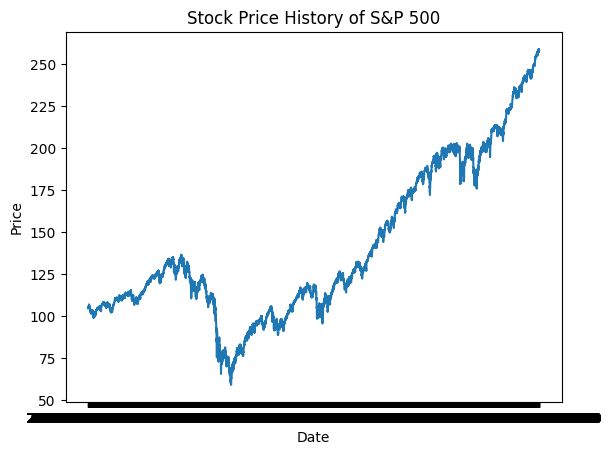

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
graph_sp500_prices=sp500.drop(columns='Type of Price')
sns.lineplot(data=graph_sp500_prices,x='Date',y='Price')
plt.title('Stock Price History of S&P 500')
plt.show()

## Method
To achieve the first goal, we will tune hyperparameters of different models to achieve the best performance possible for each type of model (based on multiple metrics)
* Split data into 80/20 proportion (4 years of training to predict 1 year of prices) to mitigate the effect of overfitting or underfitting. For training/validation, we try cross validation on time series (recommended but more computationally expensive, see code below)
* Select models appropriate for the time series context.
* Compare between model types and ascertain the best model for predicting prices based on a standardised set of metrics.
* Apply the selected model to an assortment of companies contained in the S&P500.
* The purpose of doing this will be to demonstrate whether or not this approach of model selection generalises well on stock price prediction.

The reasoning behind this approach is that the S&P500 is a traditional indicator (by definition) of the performance of the 500 most dominant stocks in Wall Street.

In [12]:
#perform unique time series cross validation (instead of stochastic selection of subsets, we select ordered subsets to train and validate models)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
train_size = int(len(sp500) * 0.8)
sp500.drop(columns=['Type of Price'],inplace=True)
sp500_train = sp500[:train_size]
sp500_test = sp500[train_size:]
tscv=TimeSeriesSplit(n_splits=5)
cv_data=[]
for train_idx,validate_idx in tscv.split(sp500_train):
  train=sp500_train.iloc[train_idx]
  validate=sp500_train.iloc[validate_idx]
  cv_data.append((train,validate))

Now we will start using time series specific modelling techniques that can capture the sequential nature of our data because of our project's method which is to use historical prices to predict future prices. This means we may exclude models like SVR or random forests which generally perform poorly when trying to capture trends in time series data. Reasons for not preferring these models include the lack of other features than price, volume (which we exclude because of our lack of justificaiton or understanding for including this feature) and date

### (Seasonal) ARIMA approach

ARIMA models are typically the first type of model we consider when trying to model time series data. ARIMA is modelled after the following equation:

$$
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

where:

$$
\Delta^d Y_t = (1 - B)^d Y_t
$$

and

$$
\epsilon_t \sim \text{white noise}
$$

Firstly, we apply normal ARIMA methods. In theory, this model should perform poorly because the data is not stationary meaning the stock price is directly or strongly affected by the date. This makes sense since our only factor so far in the modelling is time. The evidence for our theoretically poor performance of traditional ARIMA on our data set is shown through a p test of whether our data is stationary. We use an Augmented Dickey Fuller hypothesis test to find if there is sufficient evidence against the null hypothesis that our data is stationary.

In [13]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using ADF test
result = adfuller(sp500['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

ADF Statistic: 1.4665690908746367
p-value: 0.9973965330167506


It seems that there may be overwhelming evidence based on the p-value, that the data is not stationary. However, to confirm that this is likely true and not an unusual occurence, we test traditional ARIMA on the data. The metrics we will use to test suitability are AIC and BIC values.

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

We notice that the model performs very poorly from the RMSE, MAE and MSE results even if the MAPE seems to indicate the model's generally good performance. We hypothesise that this is because the model fails to capture patterns in our non-stationary data. Another reason for the model's failure is due to its lack of complexity. To intuitively provide stronger evidence against the null hypothesis that traditional ARIMA can capture the trend of stock prices, we use auto arima search on hyperparameter space with our training and validation sets. The auto arima search we will apply does not definitely provide the 'best' performing ARIMA model over a hyperparameter space either. We use this tool to determine which configuration generates the lowest AIC and BIC for finding the model of best fit.

In [15]:
%pip install pmdarima
from pmdarima.arima import auto_arima #download using pip

# best_arima=auto_arima(y=sp500_train['Price'],
#            start_p=1, start_q=1, max_p=6,max_q=6,
#            seasonal=False,
#            trace=True #so that you can see what is happening.
#)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 26.197165194309882
MAE: 19.310864702382133
MSE: 686.2914642179611
MAPE: 0.08405623546568611


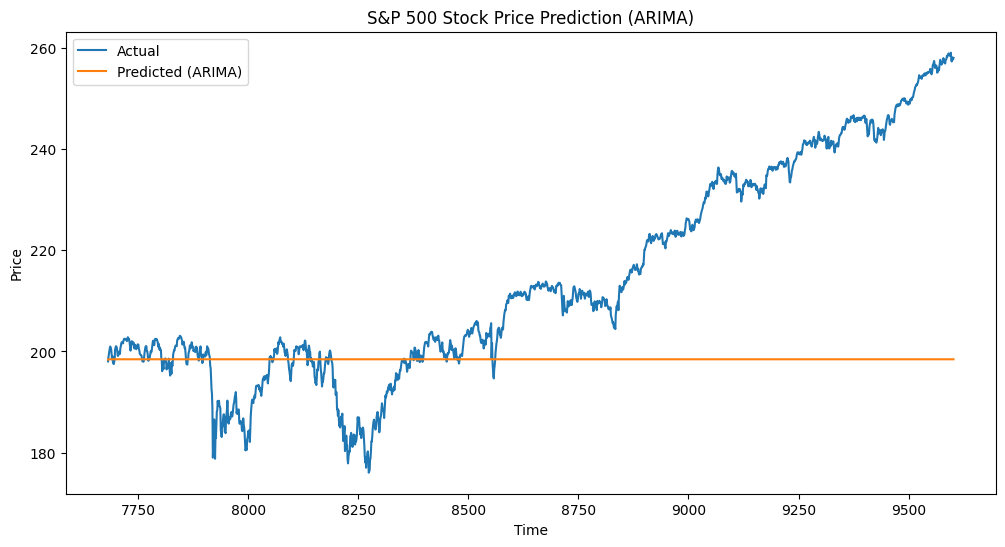

In [16]:
model = ARIMA(sp500_train['Price'], order=(3, 1, 0)) # (p, d, q)
model_fit = model.fit()
predictions = model_fit.predict(start=len(sp500_train), end=len(sp500) - 1)
rmse = mean_squared_error(sp500_test['Price'], predictions, squared=False)
mae = mean_absolute_error(sp500_test['Price'], predictions)
mse = mean_squared_error(sp500_test['Price'], predictions)
mape=mean_absolute_percentage_error(sp500_test['Price'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
plt.figure(figsize=(12, 6))
plt.plot(sp500_test['Price'], label='Actual')
plt.plot(predictions, label='Predicted (ARIMA)')
plt.title('S&P 500 Stock Price Prediction (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

From this plot, we see that the ARIMA model does indeed fail to notice the non-stationary trends in our data so it performs poorly on our data which is very much time dependent

Next we test our other null hypothesis that the data is seasonal using a p-test. We nominated Ljung-Box test because it is purported for assessing goodness of fit to ARIMA models. Here is the process of applying the test:

* Establish our hypotheses
* Fit the SARIMA model to the data
* Calculate the residuals
* Perform the Ljung-Box test on the residuals
* Interpret results

Null hypothesis: The data has no autocorrelation
Alternative hypothesis: there exists an autocorrelation relationship in the data.

Autocorrelation describes the behaviour of time series data to either have a positive or negative trend over time.

In [20]:
%pip install joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import warnings
from joblib import Parallel, delayed

def evaluate_sarima_model(train_data, validate_data, p, d, q, P, D, Q, s, early_stopping_patience=5):
    """Evaluates a single SARIMA model configuration."""
    try:
        model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit(disp=False)

        # Early stopping logic
        best_rmse = float('inf')
        patience_counter = 0
        for i in range(len(validate_data)):
            predictions = model_fit.predict(start=len(train_data), end=len(train_data) + i)
            rmse = mean_squared_error(validate_data[:i+1], predictions, squared=False)

            if rmse < best_rmse:
                best_rmse = rmse
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    break  # Stop early if RMSE doesn't improve for 'patience' iterations
        return (p, d, q, P, D, Q, s), rmse
    except:
        return None  # Return None for failed configurations

#gridsearch for best SARIMA
def grid_search_sarima_parallel(data, p_values, d_values, q_values, P_values, D_values, Q_values, s_values, n_jobs,n_splits):
    """
    Performs a grid search for SARIMA model hyperparameters using parallel computing.

    Args:
        data (pd.Series): Time series data.
        p_values (list): List of values for the AR order (p).
        d_values (list): List of values for the differencing order (d).
        q_values (list): List of values for the MA order (q).
        P_values (list): List of values for the seasonal AR order (P).
        D_values (list): List of values for the seasonal differencing order (D).
        Q_values (list): List of values for the seasonal MA order (Q).
        s_values (list): List of values for the seasonal period (s).
        n_jobs (int): Number of CPU cores to use for parallel processing (-1 for all cores).

    Returns:
        tuple: Best SARIMA model and its corresponding RMSE.
    """

    best_model = None
    best_rmse = float('inf')
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create a list of all hyperparameter combinations
    param_combinations = [(p, d, q, P, D, Q, s)
                           for p in p_values for d in d_values for q in q_values
                           for P in P_values for D in D_values for Q in Q_values
                           for s in s_values]

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        # Evaluate all model configurations in parallel
        results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_sarima_model)(data.iloc[train_idx], data.iloc[validate_idx], *params)
            for params in param_combinations
            for train_idx, validate_idx in tscv.split(data)
        )

    # Filter out failed configurations and find the best model
    valid_results = [result for result in results if result is not None]
    if valid_results:
        best_model, best_rmse = min(valid_results, key=lambda x: x[1])

    return best_model, best_rmse
grid_search_sarima_parallel(data=sp500_train['Price'],n_splits=2, p_values=[0,1,2], d_values=[0,1,2], q_values=[0,1,2], P_values=[0,1,2], D_values=[0,1,2], Q_values=[0,1,2], s_values=[0,5],n_jobs=-1)

KeyboardInterrupt: 

In [ ]:
# Fit the selected SARIMA model
model = SARIMAX(sp500_train['Price'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # (p, d, q), (P, D, Q, s)
model_fit = model.fit()
predictions = model_fit.predict(start=len(sp500_train), end=len(sp500) - 1)
# Generate residuals
residuals = model_fit.resid

# Conduct Ljung-Box test on the residuals
lb_test = acorr_ljungbox(residuals, lags=5)

print(lb_test)

The lb p value indicates that each year, there is sufficient evidence against the null that autocorrelation does not exist in the relationship between time and price. This means that every year, the behaviour of the price is not cyclic or seasonal. We note that as the number of lags increases, there seems to be stronger evidence against the null hypothesis as shown below.

In [ ]:
lb_test = acorr_ljungbox(residuals, lags=[10,20])

print(lb_test)

We may expect this to occur because smaller time intervals (for example, daily or weekly intervals as opposed to annual) likely contain a cyclic relationship between price and time due to the overall increase or decrease in price not being significant enough to yield an upwards or downwards trend.

### (G)ARCH approach
The next model is ARCH or AutoRegressive Conditional Heteroskedasticity. It is a well-known technique to use when modelling financial returns on an investment. An ARCH model is parameterised as follows:

Let  $y_t$  be a time series that is modeled as:

$$y_t = \mu + \epsilon_t$$

where:

$\mu$  is the mean,
$\epsilon_t$  is the error term, which represents the random changes at time t.

The error term  $\epsilon_t$  is assumed to have the following properties:

* $\epsilon_t$ = $\sigma_t z_t$
* $z_t$  is a white noise process with mean zero and variance 1, i.e.,  $z_t \sim N(0, 1)$ .
$\sigma_t^2$  is the conditional variance at time t.

The conditional variance is calculated as follows:

$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \cdots + \alpha_q \epsilon_{t-q}^2$

where $\alpha_i$ is a positive weight placed on each term, $\epsilon_{t}$

The heteroskedacity property of the model (the ability to predict changes in error over time) allows for the measurement of volatility. A generalised ARCH adds the element of conditonal variance of the past error term to the model. This is particularly useful in our context because we are under the assumption that historical data (past prices) has a causal effect on predicted prices.

https://www.investopedia.com/terms/g/garch.asp#:~:text=Generalized%20AutoRegressive%20Conditional%20Heteroskedasticity%20(GARCH)%20is%20used%20to%20help%20predict,believed%20to%20be%20serially%20autocorrelated.


In [ ]:
# Install arch library if not already installed
!pip install arch

from arch import arch_model

# Fit a basic GARCH(1,1) model to the training data
model_garch = arch_model(sp500_train['Price'], vol='Garch', p=1, q=1)
model_garch_fit = model_garch.fit(disp='on')

# Print model summary
print(model_garch_fit.summary())


## Evaluation and Discussion

## Conclusion